# Analysis of Forced Isotropic Flow

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import pyJHTDB
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [4]:
# pyJHTDB.interpolation_code

### Isotropic turbulence simulation with coarse mesh 

In [4]:
pyJHTDB.dbinfo.isotropic1024coarse

{'name': 'isotropic1024coarse',
 'xnodes': array([0.0000000e+00, 6.1359233e-03, 1.2271847e-02, ..., 6.2647777e+00,
        6.2709136e+00, 6.2770495e+00], dtype=float32),
 'nx': 1024,
 'lx': 6.283185307179586,
 'dx': 0.006135923151542565,
 'xperiodic': True,
 'xuniform': True,
 'ynodes': array([0.0000000e+00, 6.1359233e-03, 1.2271847e-02, ..., 6.2647777e+00,
        6.2709136e+00, 6.2770495e+00], dtype=float32),
 'ny': 1024,
 'ly': 6.283185307179586,
 'dy': 0.006135923151542565,
 'yperiodic': True,
 'yuniform': True,
 'znodes': array([0.0000000e+00, 6.1359233e-03, 1.2271847e-02, ..., 6.2647777e+00,
        6.2709136e+00, 6.2770495e+00], dtype=float32),
 'nz': 1024,
 'lz': 6.283185307179586,
 'dz': 0.006135923151542565,
 'zperiodic': True,
 'zuniform': True,
 'time': array([0.0000000e+00, 1.9999999e-03, 3.9999997e-03, ..., 1.0049999e+01,
        1.0051999e+01, 1.0054000e+01], dtype=float32),
 'diss': 0.0928,
 'nu': 0.000185}

In [5]:
!ls -lt | grep csv

-rwxrwxrwx 1 abiricz abiricz 2605373059 okt   25 01.37 Isoturb_box256_whole.csv
-rwxrwxrwx 1 abiricz abiricz  325095251 okt   25 01.35 Isoturb_box128_whole_7.csv
-rwxrwxrwx 1 abiricz abiricz  324357442 okt   25 01.35 Isoturb_box128_whole_6.csv
-rwxrwxrwx 1 abiricz abiricz  324901752 okt   25 01.34 Isoturb_box128_whole_5.csv
-rwxrwxrwx 1 abiricz abiricz  325006574 okt   25 01.34 Isoturb_box128_whole_4.csv
-rwxrwxrwx 1 abiricz abiricz  325644051 okt   25 01.34 Isoturb_box128_whole_3.csv
-rwxrwxrwx 1 abiricz abiricz  326554918 okt   25 01.33 Isoturb_box128_whole_2.csv
-rwxrwxrwx 1 abiricz abiricz  326747749 okt   25 01.33 Isoturb_box128_whole_1.csv
-rwxrwxrwx 1 abiricz abiricz  327065322 okt   25 01.30 Isoturb_box128_whole_0.csv
-rwxrwxrwx 1 abiricz abiricz 2633940222 okt   24 23.15 Isoturb_box256.csv
-rwxrwxrwx 1 abiricz abiricz  327323532 okt   24 23.14 Isoturb_box128_7.csv
-rwxrwxrwx 1 abiricz abiricz  326994109 okt   24 23.13 Isoturb_box128_6.csv
-rwxrwxrwx 1 abiricz abiricz  32808675

### Loading the data

In [5]:
%%time
#Data = pd.read_csv( 'Isoturb_coords_vels_velgrads_box128adjacent_t0.csv')
Data = pd.read_csv( '../data/Isoturb_box256_whole.csv' )

CPU times: user 34.2 s, sys: 2.34 s, total: 36.6 s
Wall time: 44.9 s


In [6]:
Data.head()

,x,y,z,v_x,v_y,v_z,d_ux_dx,d_ux_dy,d_ux_dz,d_uy_dx,d_uy_dy,d_uy_dz,d_uz_dx,d_uz_dy,d_uz_dz
0,0.0,0.0,0.000000,-0.663504,-1.065386,-0.136499,2.981136,-5.617271,1.933735,0.829567,3.566788,13.611511,-2.947208,4.304368,-5.640903
1,0.0,0.0,0.024544,-0.508451,-0.933564,-0.109632,-13.324913,2.773506,-0.915855,6.056847,5.923958,-2.049797,-7.612086,-0.821135,7.267926
2,0.0,0.0,0.049087,-0.534200,-1.047866,-0.125243,-4.009998,3.711887,3.335771,-1.119186,6.444824,-11.487570,-7.881467,-3.499416,-2.156832
3,0.0,0.0,0.073631,-0.432109,-1.105009,-0.290081,0.110847,4.324562,-1.195167,12.471207,0.613502,8.197377,-20.606530,-27.143791,-2.894118
4,0.0,0.0,0.098175,-0.350130,-0.674686,-0.554334,5.165487,-8.374277,13.552773,1.943451,7.192371,5.237011,-20.873447,-13.913181,-12.439633


In [7]:
Data.isnull().values.any()

False

In [8]:
def packing_to_3d(array_1d, L):
    array_3d = empty( (L, L, L), dtype=float )
    for i in range(L):
        for j in range(L):
            for k in range(L):
                array_3d[i,j,k] = array_1d[ k + L*( j + L*i ) ]
    return array_3d

## Calculating velocity gradient by FFT

### Calculating wavenumbers

In [9]:
xnodes = unique( Data['x'] )
ynodes = unique( Data['y'] )
znodes = unique( Data['z'] )

In [10]:
dx = xnodes[1]-xnodes[0]
dy = ynodes[1]-ynodes[0]
dz = znodes[1]-znodes[0]
dx, dy, dz

(0.024543693, 0.024543693, 0.024543693)

In [11]:
L = xnodes.shape[0]
L

256

In [12]:
lx = L*dx
ly = L*dy
lz = L*dz

In [13]:
dkx = 2*pi / lx
dky = 2*pi / ly
dkz = 2*pi / lz

In [14]:
kx_max = pi / dx
ky_max = pi / dy
kz_max = pi / dz

In [15]:
dx, lx, dkx, kx_max

(0.024543693, 6.283185408, 0.9999999839539331, 127.99999794610343)

In [16]:
kx = np.fft.fftfreq(L, d = dx)*2*pi
kx.shape, kx[:65]

((256,),
 array([ 0.        ,  0.99999998,  1.99999997,  2.99999995,  3.99999994,
         4.99999992,  5.9999999 ,  6.99999989,  7.99999987,  8.99999986,
         9.99999984, 10.99999982, 11.99999981, 12.99999979, 13.99999978,
        14.99999976, 15.99999974, 16.99999973, 17.99999971, 18.9999997 ,
        19.99999968, 20.99999966, 21.99999965, 22.99999963, 23.99999961,
        24.9999996 , 25.99999958, 26.99999957, 27.99999955, 28.99999953,
        29.99999952, 30.9999995 , 31.99999949, 32.99999947, 33.99999945,
        34.99999944, 35.99999942, 36.99999941, 37.99999939, 38.99999937,
        39.99999936, 40.99999934, 41.99999933, 42.99999931, 43.99999929,
        44.99999928, 45.99999926, 46.99999925, 47.99999923, 48.99999921,
        49.9999992 , 50.99999918, 51.99999917, 52.99999915, 53.99999913,
        54.99999912, 55.9999991 , 56.99999909, 57.99999907, 58.99999905,
        59.99999904, 60.99999902, 61.99999901, 62.99999899, 63.99999897]))

In [17]:
ky = kx
kz = kx

### Creating meshgrid, test of indexing

In [18]:
X, Y, Z = meshgrid(xnodes, ynodes, znodes, indexing = 'ij')

In [19]:
%%time
VX = packing_to_3d(array(Data['v_x']), L)
VY = packing_to_3d(array(Data['v_y']), L)
VZ = packing_to_3d(array(Data['v_z']), L)

CPU times: user 13.4 s, sys: 0 ns, total: 13.4 s
Wall time: 13.4 s


In [21]:
X[0, 1, 2], Y[0, 1, 2], Z[0, 1, 2]

(0.0, 0.024543693, 0.049087387)

In [22]:
VX[0, 1, 2], VY[0, 1, 2], VZ[0, 1, 2]

(-0.45517057, -0.8036783000000001, -0.20844272)

In [23]:
Data.loc[128*128*0+128*1+2]

x          0.000000
y          0.000000
z          3.190680
v_x       -1.676081
v_y       -0.275203
v_z        0.396002
d_ux_dx    0.539612
d_ux_dy    2.711227
d_ux_dz   -1.072771
d_uy_dx   -8.692432
d_uy_dy   -1.236157
d_uy_dz   -1.897618
d_uz_dx    1.706730
d_uz_dy    2.704956
d_uz_dz    0.216889
Name: 130, dtype: float64

### Important notes to the Fourier spectral derivation method

https://math.mit.edu/~stevenj/fft-deriv.pdf

"...Essentially, adding the mN term to k means that the interpolated function y(x) just
oscillates m extra times in between the sample points, i.e. between n and n + 1, which has no effect on
yn but has a huge effect on derivatives. To resolve this ambiguity, one imposes additional criteria—e.g. a
bandlimited spectrum and/or minimizing some derivative of the interpolated y(x)—and we will then explore
the consequences of the disambiguated interpolation for various derivative operations..."

In [24]:
def fft_3d_derivate( VX ):
    VX_k = np.fft.rfftn( VX, axes = (0,1,2) )
    d_VX_k_dkx = zeros( [L, L, int(L/2)+1], dtype = complex )
    for i in range(L): # runs in y dim
        for j in range(int(L/2)+1): # runs in z dim -> only positive k (!)
            d_VX_k_dkx[:, i, j] = VX_k[:, i, j] *1j * kx[:]
            d_VX_k_dkx[int(L/2), i, j] = 0 # Nyquist must be zero (!)
            
    d_VX_k_dky = zeros( [L, L, int(L/2)+1], dtype = complex )
    for i in range(L): # runs in x dim
        for j in range(int(L/2)+1): # runs in z dim -> only positive k (!)
            d_VX_k_dky[i, :, j] = VX_k[i, :, j] *1j * ky[:]
            d_VX_k_dky[i, int(L/2), j] = 0 # Nyquist must be zero (!)
            
    d_VX_k_dkz = zeros( [L, L, int(L/2)+1], dtype = complex )
    for i in range(L): # runs in x dim
        for j in range(L): # runs in y dim
            d_VX_k_dkz[i, j, :] = VX_k[i, j, :] *1j * kz[:int(L/2)+1]
            d_VX_k_dkz[i, j, int(L/2)] = 0 # Nyquist must be zero (!)
            
    d_VX_dx = irfftn(d_VX_k_dkx, axes = (0, 1, 2))
    d_VX_dy = irfftn(d_VX_k_dkx, axes = (0, 1, 2))
    d_VX_dz = irfftn(d_VX_k_dkx, axes = (0, 1, 2))
    return d_VX_dx, d_VX_dy, d_VX_dz

In [25]:
%%time
d_ux_dx_array = packing_to_3d( array(Data['d_ux_dx']), L )
d_ux_dy_array = packing_to_3d( array(Data['d_ux_dy']), L )
d_ux_dz_array = packing_to_3d( array(Data['d_ux_dz']), L )

d_uy_dx_array = packing_to_3d( array(Data['d_uy_dx']), L )
d_uy_dy_array = packing_to_3d( array(Data['d_uy_dy']), L )
d_uy_dz_array = packing_to_3d( array(Data['d_uy_dz']), L )

d_uz_dx_array = packing_to_3d( array(Data['d_uz_dx']), L )
d_uz_dy_array = packing_to_3d( array(Data['d_uz_dy']), L )
d_uz_dz_array = packing_to_3d( array(Data['d_uz_dz']), L )

CPU times: user 39.7 s, sys: 330 ms, total: 40 s
Wall time: 40 s


### Validating the spectral derivatives with the finite difference method

In [26]:
Xnodes, Ynodes = meshgrid( xnodes, ynodes, indexing='ij')

In [27]:
%%time
d_VX_dx, d_VX_dy, d_VX_dz = fft_3d_derivate( VX )
d_VY_dx, d_VY_dy, d_VY_dz = fft_3d_derivate( VY )
d_VZ_dx, d_VZ_dy, d_VZ_dz = fft_3d_derivate( VZ )

CPU times: user 11.9 s, sys: 4.32 s, total: 16.2 s
Wall time: 16.2 s


Text(0,0.5,'y')

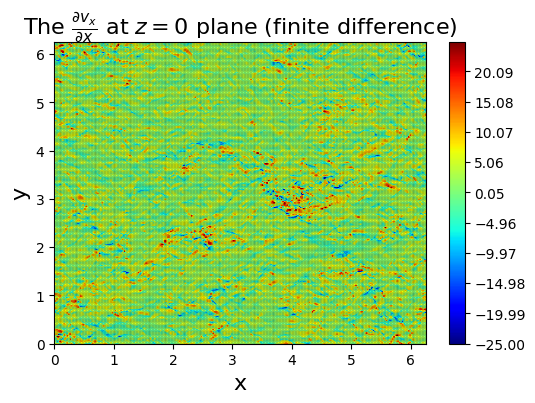

In [28]:
fig = plt.figure( figsize=(6,4), dpi=100 )
plt.plot( Xnodes, Ynodes, color='black', marker='.', linestyle='none', markersize=0.1 )
plt.contourf( xnodes, ynodes, d_ux_dx_array[:, :, 0], np.linspace(-25, 25, num=500), cmap='jet' )
plt.title( 'The $\\frac{\partial v_x}{\partial x}$ at $z = 0$ plane (finite difference)', fontsize=16 )
cbar = plt.colorbar()
#cbar.set_label( '$v_z$', rotation=270, labelpad=35, fontsize=16 )
plt.xlabel( 'x', fontsize=16 )
plt.ylabel( 'y', fontsize=16 )
#plt.savefig( 'dvxdx_testplot_z0_fd_adjacent.png', dpi=200 )

Text(0,0.5,'y')

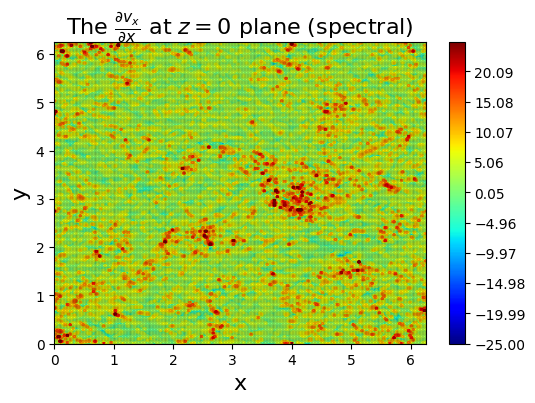

In [29]:
fig = plt.figure( figsize=(6,4), dpi=100 )
plt.plot( Xnodes, Ynodes, color='black', marker='.', linestyle='none', markersize=0.1 )
plt.contour( xnodes, ynodes, d_VX_dx[:, :, 0], np.linspace(-25, 25, num=500), cmap='jet' )
plt.title( 'The $\\frac{\partial v_x}{\partial x}$ at $z = 0$ plane (spectral)', fontsize=16 )
cbar = plt.colorbar()
#cbar.set_label( '$v_z$', rotation=270, labelpad=35, fontsize=16 )
plt.xlabel( 'x', fontsize=16 )
plt.ylabel( 'y', fontsize=16 )
#plt.savefig( 'dvxdx_testplot_z0_fft_adjacent.png', dpi=200 )

In [30]:
diff = d_VX_dx[:, :, 0] - d_ux_dx_array[:, :, 0]

Text(0,0.5,'y')

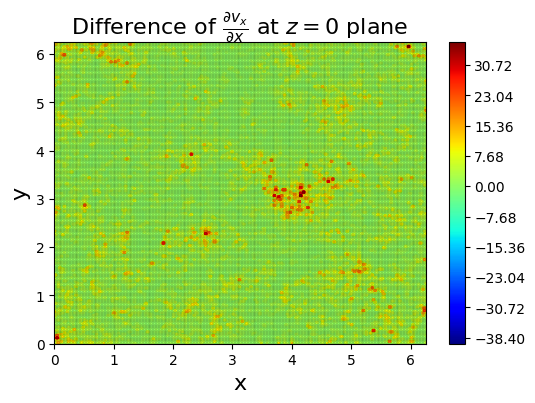

In [31]:
fig = plt.figure( figsize=(6,4), dpi=100 )
scale = np.linspace( 0.9*np.min( diff ), 1.1*np.max( diff ), num=1000 )
plt.plot( Xnodes, Ynodes, color='black', marker='.', linestyle='none', markersize=0.1 )
plt.contour( xnodes, ynodes, diff, 1000, cmap='jet' )
plt.title( 'Difference of $\\frac{\partial v_x}{\partial x}$ at $z = 0$ plane', fontsize=16 )
cbar = plt.colorbar()
#cbar.set_label( '$v_z$', rotation=270, labelpad=35, fontsize=16 )
plt.xlabel( 'x', fontsize=16 )
plt.ylabel( 'y', fontsize=16 )
#plt.savefig( 'dvxdx_testplot_z0_adjacent.png', dpi=200 )

Text(0,0.5,'values')

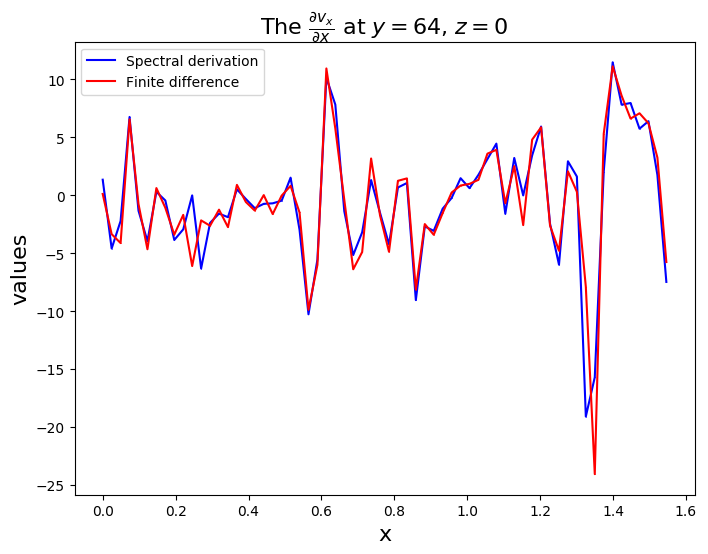

In [32]:
fig = plt.figure( figsize=(8,6), dpi=100 )
plt.plot( Xnodes[:,64][:64], d_VX_dx[:, 64, 0][:64], color='blue', marker='x', linestyle='-', markersize=0.1, label='Spectral derivation' )
plt.plot( Xnodes[:,64][:64], d_ux_dx_array[:, 64, 0][:64], color='red', marker='x', linestyle='-', markersize=0.1, label='Finite difference' )
#plt.plot( Xnodes[:,64][:64], (d_VX_dx[:, 64, 0]-d_ux_dx_array[:, 64, 0])[:64], color='black', marker='.', linestyle='--', markersize=0.1, label='Difference' )
plt.legend()
plt.title( 'The $\\frac{\partial v_x}{\partial x}$ at $y=64$, $z = 0$', fontsize=16 )
plt.xlabel( 'x', fontsize=16 )
plt.ylabel( 'values', fontsize=16 )
plt.savefig( 'dvxdx_slice_adjacent.png', dpi=100 )

Text(0,0.5,'values')

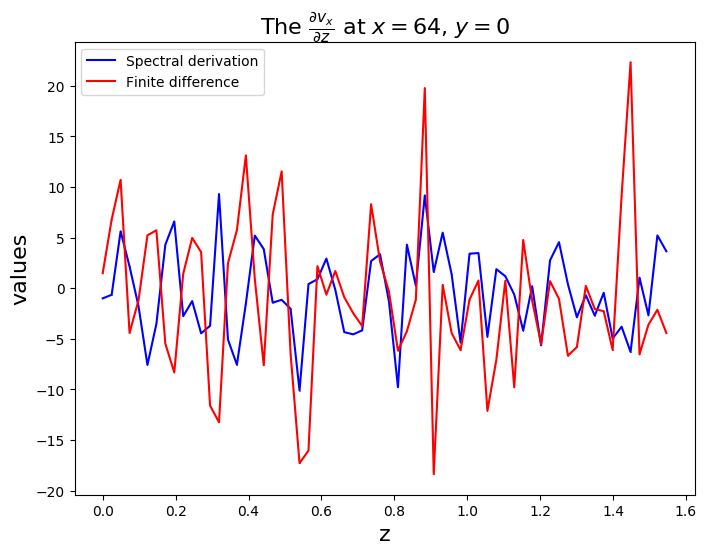

In [33]:
fig = plt.figure( figsize=(8,6), dpi=100 )
plt.plot( Xnodes[:,64][:64], d_VX_dz[64, 0, :][:64], color='blue', marker='x', linestyle='-', markersize=0.1, label='Spectral derivation' )
plt.plot( Xnodes[:,64][:64], d_ux_dz_array[64, 0, :][:64], color='red', marker='x', linestyle='-', markersize=0.1, label='Finite difference' )
#plt.plot( Xnodes[:,64][:64], (d_VX_dx[:, 64, 0]-d_ux_dx_array[:, 64, 0])[:64], color='black', marker='.', linestyle='--', markersize=0.1, label='Difference' )
plt.legend()
plt.title( 'The $\\frac{\partial v_x}{\partial z}$ at $x=64$, $y = 0$', fontsize=16 )
plt.xlabel( 'z', fontsize=16 )
plt.ylabel( 'values', fontsize=16 )
plt.savefig( 'dvxdz_slice_adjacent.png', dpi=100 )

Text(0,0.5,'values')

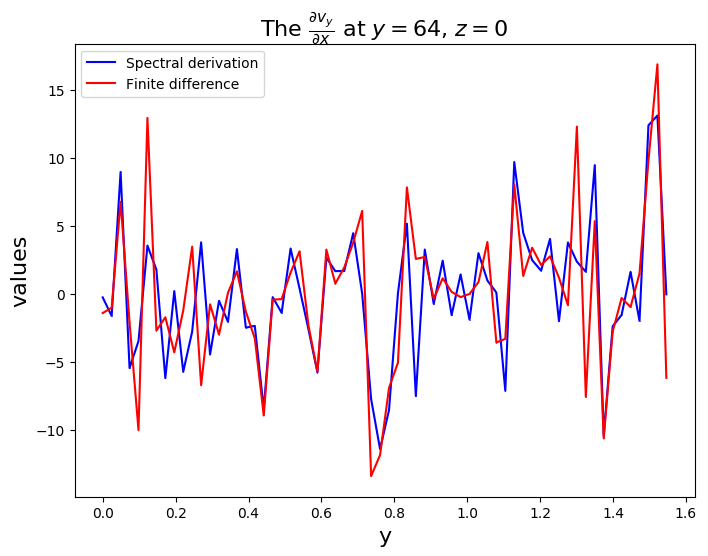

In [34]:
fig = plt.figure( figsize=(8,6), dpi=100 )
plt.plot( Xnodes[:,64][:64], d_VY_dx[:, 64, 0][:64], color='blue', marker='x', linestyle='-', markersize=0.1, label='Spectral derivation' )
plt.plot( Xnodes[:,64][:64], d_uy_dx_array[:, 64, 0][:64], color='red', marker='x', linestyle='-', markersize=0.1, label='Finite difference' )
#plt.plot( Xnodes[:,64][:64], (d_VX_dx[:, 64, 0]-d_ux_dx_array[:, 64, 0])[:64], color='black', marker='.', linestyle='--', markersize=0.1, label='Difference' )
plt.legend()
plt.title( 'The $\\frac{\partial v_y}{\partial x}$ at $y=64$, $z = 0$', fontsize=16 )
plt.xlabel( 'y', fontsize=16 )
plt.ylabel( 'values', fontsize=16 )
plt.savefig( 'dvydx_slice_adjacent.png', dpi=300 )

Text(0,0.5,'values')

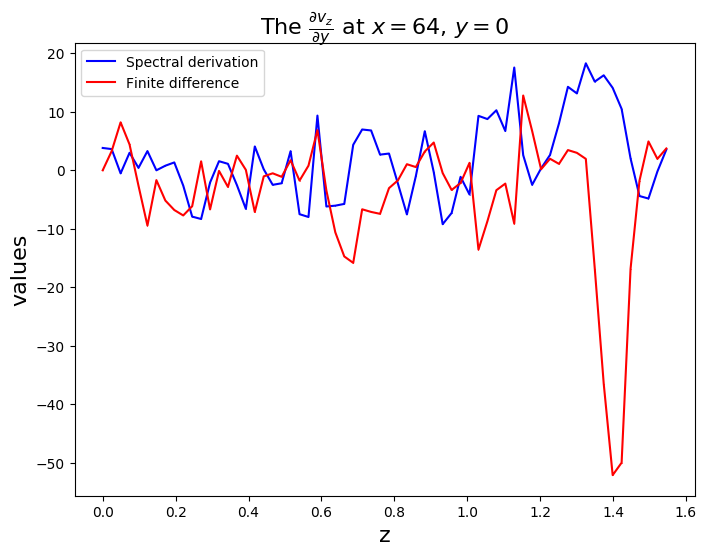

In [35]:
fig = plt.figure( figsize=(8,6), dpi=100 )
plt.plot( Xnodes[:,64][:64], d_VZ_dy[64, 0, :][:64], color='blue', marker='x', linestyle='-', markersize=0.1, label='Spectral derivation' )
plt.plot( Xnodes[:,64][:64], d_uz_dy_array[64, 0, :][:64], color='red', marker='x', linestyle='-', markersize=0.1, label='Finite difference' )
#plt.plot( Xnodes[:,64][:64], (d_VX_dx[:, 64, 0]-d_ux_dx_array[:, 64, 0])[:64], color='black', marker='.', linestyle='--', markersize=0.1, label='Difference' )
plt.legend()
plt.title( 'The $\\frac{\partial v_z}{\partial y}$ at $x=64$, $y = 0$', fontsize=16 )
plt.xlabel( 'z', fontsize=16 )
plt.ylabel( 'values', fontsize=16 )
plt.savefig( 'dvzdy_slice_adjacent.png', dpi=300 )

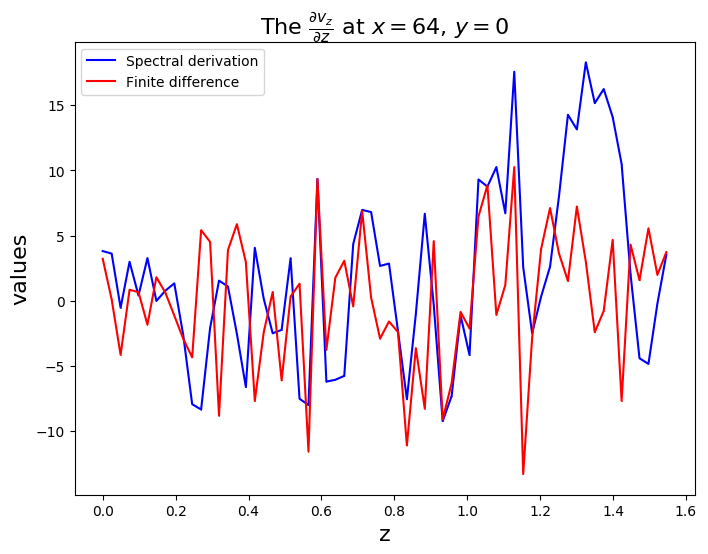

In [37]:
fig = plt.figure( figsize=(8,6), dpi=100 )
plt.plot( Xnodes[:,64][:64], d_VZ_dz[64, 0, :][:64], color='blue', marker='x', linestyle='-', markersize=0.1, label='Spectral derivation' )
plt.plot( Xnodes[:,64][:64], d_uz_dz_array[64, 0, :][:64], color='red', marker='x', linestyle='-', markersize=0.1, label='Finite difference' )
#plt.plot( Xnodes[:,64][:64], (d_VX_dx[:, 64, 0]-d_ux_dx_array[:, 64, 0])[:64], color='black', marker='.', linestyle='--', markersize=0.1, label='Difference' )
plt.legend()
plt.title( 'The $\\frac{\partial v_z}{\partial z}$ at $x=64$, $y = 0$', fontsize=16 )
plt.xlabel( 'z', fontsize=16 )
plt.ylabel( 'values', fontsize=16 )
plt.savefig( 'dvzdz_slice_adjacent.png', dpi=100 )

In [38]:
Data.head()

,x,y,z,v_x,v_y,v_z,d_ux_dx,d_ux_dy,d_ux_dz,d_uy_dx,d_uy_dy,d_uy_dz,d_uz_dx,d_uz_dy,d_uz_dz
0,0.0,0.0,0.000000,-0.663504,-1.065386,-0.136499,2.981136,-5.617271,1.933735,0.829567,3.566788,13.611511,-2.947208,4.304368,-5.640903
1,0.0,0.0,0.024544,-0.508451,-0.933564,-0.109632,-13.324913,2.773506,-0.915855,6.056847,5.923958,-2.049797,-7.612086,-0.821135,7.267926
2,0.0,0.0,0.049087,-0.534200,-1.047866,-0.125243,-4.009998,3.711887,3.335771,-1.119186,6.444824,-11.487570,-7.881467,-3.499416,-2.156832
3,0.0,0.0,0.073631,-0.432109,-1.105009,-0.290081,0.110847,4.324562,-1.195167,12.471207,0.613502,8.197377,-20.606530,-27.143791,-2.894118
4,0.0,0.0,0.098175,-0.350130,-0.674686,-0.554334,5.165487,-8.374277,13.552773,1.943451,7.192371,5.237011,-20.873447,-13.913181,-12.439633


### Calculating and saving important quantities

#### Rotation of the velocity field (angular speed)

$\omega = \nabla \times u$

In [39]:
d_VX_dz.shape

(256, 256, 256)

In [40]:
WX = d_VZ_dy - d_VY_dz
WY = d_VX_dz - d_VZ_dx
WZ = d_VY_dx - d_VX_dy

In [41]:
Data['omega_x'] = Data['d_uz_dy'] - Data['d_uy_dz']
Data['omega_y'] = Data['d_ux_dz'] - Data['d_uz_dx']
Data['omega_z'] = Data['d_uy_dx'] - Data['d_ux_dy']

In [42]:
WX[1, 2, 2], WY[1, 2, 2], WZ[1, 2, 2]

(-18.19757595699499, 11.450762223699101, 6.746813733295886)

In [44]:
# Data.loc[128*128*1+128*2+2]

#### Enstrophy: $S = \frac{1}{2} \omega^2$

In [45]:
Enstrophy = 0.5*( WX**2 + WY**2 + WZ**2 )
Enstrophy.shape

(256, 256, 256)

In [46]:
Data['enstrophy'] = 0.5*( Data['omega_x']**2 + Data['omega_y']**2 + Data['omega_z']**2 )

#### Energy: $E = \frac{1}{2}v^2$

In [47]:
Energy = 0.5*VX**2 + 0.5*VY**2 + 0.5*VZ**2
Energy.shape

(256, 256, 256)

In [48]:
Data['energy'] = 0.5*( Data['v_x']**2 + Data['v_y']**2 + Data['v_z']**2 )

#### Dissipation: 

$S^2 = S_{ij} S_{ij}$, where $S_{ij} = \frac{1}{2} (\nabla u + \nabla u^T)_{ij}$

Q, R are other two scalar invariants of the velocity gradient tensor

#### This is calculated by a 3x3 matrix at each node (!)

In [ ]:
%%time
V_grad_matrix = empty( (3,3), dtype=float )
S_ij = empty( (3,3), dtype=float )
S_square = empty( VX.shape, dtype=float )
R = empty( VX.shape, dtype=float )
for k in range( VX.shape[0] ):
    for l in range( VY.shape[1] ):
        for m in range( VZ.shape[2] ):
            V_grad_matrix[0,0] = d_VX_dx[k, l, m]
            V_grad_matrix[0,1] = d_VY_dx[k, l, m]
            V_grad_matrix[0,2] = d_VZ_dx[k, l, m]
            V_grad_matrix[1,0] = d_VX_dy[k, l, m]
            V_grad_matrix[1,1] = d_VY_dy[k, l, m]
            V_grad_matrix[1,2] = d_VZ_dy[k, l, m]
            V_grad_matrix[2,0] = d_VX_dz[k, l, m]
            V_grad_matrix[2,1] = d_VY_dz[k, l, m]
            V_grad_matrix[2,2] = d_VZ_dz[k, l, m]
            
            S_ij = 0.5*( V_grad_matrix + V_grad_matrix.T )
            S_square[k, l, m] = sum( S_ij**2 )
            
            R[k, l, m] = -1 * linalg.det(V_grad_matrix)

Q = 0.5 * Enstrophy - S_square

In [48]:
S_square[0,0,:8], R[0,0,:8], Q[0,0,:8]

(array([ 149.87511916,  362.57811952,  409.83439887,  563.4505788 ,
          19.93168065, 1016.02603812,  668.16741284, 1536.54298056]),
 array([-0., -0., -0., -0., -0., -0., -0., -0.]),
 array([ -118.5068757 ,  -252.42059952,  -337.65792317,  -398.83716884,
          -11.37867056,  -515.41854066,  -490.11592035, -1428.63458402]))

In [49]:
vel_grad_at_points = empty( (Data['x'].shape[0], 9) )
vel_grad_at_points.shape

(16777216, 9)

In [50]:
vel_grad_at_points[:,0] = Data['d_ux_dx']
vel_grad_at_points[:,1] = Data['d_ux_dy']
vel_grad_at_points[:,2] = Data['d_ux_dz']
vel_grad_at_points[:,3] = Data['d_uy_dx']
vel_grad_at_points[:,4] = Data['d_uy_dy']
vel_grad_at_points[:,5] = Data['d_uy_dz']
vel_grad_at_points[:,6] = Data['d_uz_dx']
vel_grad_at_points[:,7] = Data['d_uz_dy']
vel_grad_at_points[:,8] = Data['d_uz_dz']

In [51]:
Data.head()

,x,y,z,v_x,v_y,v_z,d_ux_dx,d_ux_dy,d_ux_dz,d_uy_dx,d_uy_dy,d_uy_dz,d_uz_dx,d_uz_dy,d_uz_dz,omega_x,omega_y,omega_z,enstrophy,energy
0,0.0,0.0,0.000000,-0.663504,-1.065386,-0.136499,2.981136,-5.617271,1.933735,0.829567,3.566788,13.611511,-2.947208,4.304368,-5.640903,-9.307143,4.880942,6.446838,76.004117,0.796958
1,0.0,0.0,0.024544,-0.508451,-0.933564,-0.109632,-13.324913,2.773506,-0.915855,6.056847,5.923958,-2.049797,-7.612086,-0.821135,7.267926,1.228661,6.696232,3.283340,28.564725,0.571042
2,0.0,0.0,0.049087,-0.534200,-1.047866,-0.125243,-4.009998,3.711887,3.335771,-1.119186,6.444824,-11.487570,-7.881467,-3.499416,-2.156832,7.988154,11.217238,-4.831074,106.488154,0.699540
3,0.0,0.0,0.073631,-0.432109,-1.105009,-0.290081,0.110847,4.324562,-1.195167,12.471207,0.613502,8.197377,-20.606530,-27.143791,-2.894118,-35.341168,19.411364,8.146645,846.083507,0.745955
4,0.0,0.0,0.098175,-0.350130,-0.674686,-0.554334,5.165487,-8.374277,13.552773,1.943451,7.192371,5.237011,-20.873447,-13.913181,-12.439633,-19.150192,34.426220,10.317728,829.174976,0.442539


In [52]:
vel_grad_at_points_matrices = reshape(vel_grad_at_points, [vel_grad_at_points.shape[0], 3, 3])

In [53]:
vel_grad_at_points_matrices.shape

(16777216, 3, 3)

In [54]:
%%time
S_matrices = zeros(vel_grad_at_points_matrices.shape)
S_squares = zeros(vel_grad_at_points_matrices.shape[0])
for i in range(vel_grad_at_points_matrices.shape[0]):
    S_matrices[i] = 0.5*(vel_grad_at_points_matrices[i] + vel_grad_at_points_matrices[i].T)
    S_squares[i] = sum(S_matrices[i]**2)
Data['dissipation'] = S_squares

CPU times: user 2min 45s, sys: 477 ms, total: 2min 46s
Wall time: 2min 46s


### Requesting data for excursion sets

Excursion set indicator function for a scalar field $A(x)$:

$ \Theta^A_\chi (x) = H(A(x)-\chi) = 
\begin{cases}
1, ~if ~A(x) \geq \chi \\
0, ~otherwise
\end{cases}$

Excursion set for the enstrophy for the threshold $\chi = 20 \langle S^2 \rangle$:

$E_{\chi} (x) = E (x) \Theta^{E}_\chi (x) = E (x) \Theta^{E}_{20 \langle S^2 \rangle} (x) = 
\begin{cases}
E(x), ~if ~E(x) \geq 20 \langle S^2 \rangle \\
0, ~otherwise
\end{cases}$

#### In theory: $\langle S^2 \rangle = \frac{1}{2} \langle \omega^2 \rangle$ for isotropic turbulent flow.
Let's check:

## Validation? 

In [55]:
S_square_mean = mean(S_square)
enstrophy_mean = mean(Enstrophy)
S_square_mean, enstrophy_mean, mean(S_squares), mean(Data['enstrophy'])

(284.76102494628157, 142.07607084526916, 240.228372790183, 240.0654457589671)

### Using the results of the finite difference method

In [56]:
Energy = packing_to_3d( array( Data['energy'] ), L )
Enstrophy = packing_to_3d( array( Data['enstrophy'] ), L )
S_square = packing_to_3d( S_squares, L )

In [57]:
Energy.shape, Enstrophy.shape, S_square.shape

((256, 256, 256), (256, 256, 256), (256, 256, 256))

In [58]:
threshold = 20*mean( Enstrophy )
indices = argwhere( Enstrophy > threshold )
indices.shape, indices[:3]

((39636, 3), array([[  0,   3, 107],
        [  0,   3, 108],
        [  0,   3, 109]]))

In [59]:
theta = zeros( VX.shape, dtype=int )
theta.shape

(256, 256, 256)

In [60]:
# set corresponding values to 1
for i in range( indices.shape[0] ):
    theta[ indices[i,0], indices[i,1], indices[i,2] ] = 1

In [61]:
sum(theta)

39636

### Computing the correlation function (in Fourier space)

In [62]:
abs_theta_k = np.abs( fft.rfftn( theta, axes=(0,1,2), norm="ortho" ) )**2
abs_theta_k.shape

(256, 256, 129)

In [63]:
Cr = fft.irfftn( abs_theta_k, axes=(0,1,2), norm="ortho" )
Cr.shape

(256, 256, 256)

In [64]:
Cr[0,0,0]

9.6767578125

In [65]:
np.max(Cr)

9.6767578125

### Angular average of the correlation function

In [66]:
r = sqrt( X[:,0,0]**2 + Y[0,:,0]**2 + Z[0,0,:]**2 )

In [20]:
%%time
points = np.array(list(itertools.product(xnodes, ynodes, znodes ) ) ) 

CPU times: user 6.88 s, sys: 312 ms, total: 7.19 s
Wall time: 7.16 s


In [21]:
points[:8]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.02454369],
       [0.        , 0.        , 0.04908739],
       [0.        , 0.        , 0.07363108],
       [0.        , 0.        , 0.09817477],
       [0.        , 0.        , 0.12271847],
       [0.        , 0.        , 0.14726216],
       [0.        , 0.        , 0.17180586]])

In [22]:
Cr.shape

NameError: name 'Cr' is not defined

In [70]:
Cr_points = Cr.flatten()

In [71]:
Cr_points.shape, points.shape

((16777216,), (16777216, 3))

#### Converting coordinates to spherical coordinate system

In [24]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy) # elevation - theta
    az = np.arctan2(y, x) # azimuth - phi
    return r, el, az

In [25]:
%%time
points_sphere = empty( points.shape, dtype=float )
for i in range( points.shape[0] ):
    points_sphere[i] = cart2sph( *points[i] )

CPU times: user 2min 19s, sys: 192 ms, total: 2min 19s
Wall time: 2min 19s


In [26]:
points_sphere.shape, points_sphere[:8]

((16777216, 3), array([[0.        , 0.        , 0.        ],
        [0.02454369, 1.57079633, 0.        ],
        [0.04908739, 1.57079633, 0.        ],
        [0.07363108, 1.57079633, 0.        ],
        [0.09817477, 1.57079633, 0.        ],
        [0.12271847, 1.57079633, 0.        ],
        [0.14726216, 1.57079633, 0.        ],
        [0.17180586, 1.57079633, 0.        ]]))

#### Sorting for radii values

In [27]:
# sorting indices for the coordinates, sorts ONLY with radius
sort_idx = argsort( points_sphere, axis=0 ) 
sort_idx[:8]

array([[       0,        0,        0],
       [       1, 16082432, 13959416],
       [   65536,  8121344, 13959417],
       [     256, 15810560, 13959418],
       [   65537,  5617920, 13959419],
       [   65792,  3976192, 13959420],
       [     257, 13458176, 13959421],
       [   65793,  7014144,  2818303]])

In [28]:
%%time
# sorting indices for the coordinates, sort EVERY column, but radius is the primary
sort_idx = lexsort( (points_sphere[:,2], points_sphere[:,1], points_sphere[:,0]) )
sort_idx

CPU times: user 5.69 s, sys: 27.9 ms, total: 5.72 s
Wall time: 5.72 s


In [29]:
# points_sphere_r_sorted = points_sphere[ sort_idx[:,0] ]
points_sphere_r_sorted = points_sphere[ sort_idx ]

In [30]:
points_sphere_r_sorted[:8]

array([[0.        , 0.        , 0.        ],
       [0.02454369, 0.        , 0.        ],
       [0.02454369, 0.        , 1.57079633],
       [0.02454369, 1.57079633, 0.        ],
       [0.03471002, 0.        , 0.78539816],
       [0.03471002, 0.78539816, 0.        ],
       [0.03471002, 0.78539816, 1.57079633],
       [0.04251092, 0.61547971, 0.78539816]])

#### Sorting the two-point correlation function's values with these indices

In [79]:
Cr_points

array([9.67675781, 0.87475586, 0.33251953, ..., 0.1953125 , 0.27685547,
       0.40844727])

In [80]:
Cr_r_sorted = Cr_points[ sort_idx ]
Cr_r_sorted

array([9.67675781, 0.88085938, 0.92651367, ..., 0.28125   , 0.2668457 ,
       0.40844727])

#### Separating each surface for integration

In [81]:
diff_between_radii = np.diff(points_sphere_r_sorted[:,0])
boundaries = argwhere( [ not i for i in isclose( diff_between_radii, 0, atol=0.7*1e-5 ) ] )
boundaries.shape

(139637, 1)

In [82]:
diff_between_radii[:15]

array([0.02454369, 0.        , 0.        , 0.01016633, 0.        ,
       0.        , 0.0078009 , 0.00657646, 0.        , 0.        ,
       0.00579398, 0.        , 0.        , 0.        , 0.        ])

In [83]:
true_boundaries = boundaries.reshape( boundaries.shape[0] )+1
true_boundaries[:10]

array([ 1,  4,  7,  8, 11, 17, 20, 23, 29, 35])

#### Validation of the separation

In [84]:
points_sphere_r_sorted[16:21,0]

array([0.05488137, 0.06011953, 0.06011953, 0.06011953, 0.06942005])

In [85]:
#true_boundaries[20000:20002]

In [86]:
# points_sphere_r_sorted[true_boundaries[20000]:true_boundaries[20002],0]

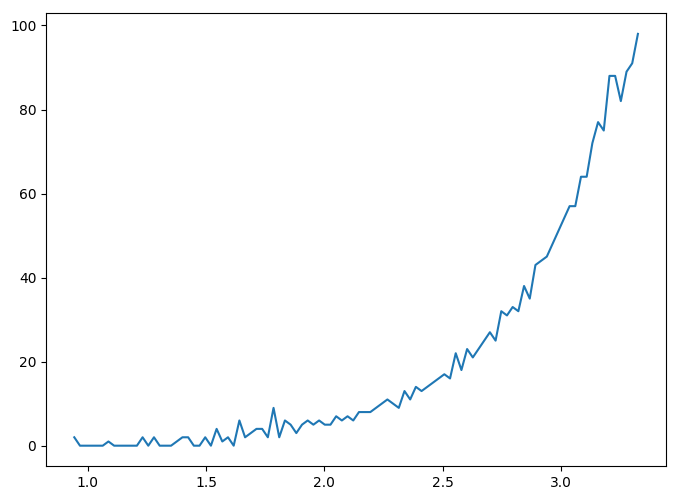

In [31]:
plt.figure( figsize=(8,6), dpi=100 )
freq, bins = histogram( np.log10(points_sphere[1:2000,0]/0.0028), bins=100 )
plt.plot( bins[:-1], freq )
# plt.savefig( 'radial_points_distribution.png', dpi=100)

#### Preparing for writing integrator function

In [88]:
# true_boundaries[300:302]

In [89]:
# points_sphere_r_sorted[ true_boundaries[300]:true_boundaries[301],: ]

In [90]:
distance = mean(points_sphere_r_sorted[true_boundaries[300]:true_boundaries[301],0])
surface = points_sphere_r_sorted[true_boundaries[300]:true_boundaries[301],1:]
values = Cr_r_sorted[true_boundaries[300]:true_boundaries[301]]

In [91]:
print("Surface at radius:", distance)
for i in range(values.shape[0]):
    print("Function value:", values[i], "\ttheta:", surface[i,0], "\tphi:", surface[i,1] )

Surface at radius: 0.4643884652721112
Function value: 0.05029296875 	theta: 0.1592268960047592 	phi: 0.2709468631802634
Function value: 0.053955078125 	theta: 0.1592268960047592 	phi: 1.2998494636146332
Function value: 0.04638671875 	theta: 0.26743472396053747 	phi: 0.16514868108522732
Function value: 0.049560546875 	theta: 0.26743472396053747 	phi: 1.4056476457096694
Function value: 0.055419921875 	theta: 1.2575218438440483 	phi: 0.5404194882871538
Function value: 0.047119140625 	theta: 1.2575218438440483 	phi: 1.0303768385077428
Function value: 0.046142578125 	theta: 0.49571960536642856 	phi: 0.5713374415904768
Function value: 0.04541015625 	theta: 0.49571960536642856 	phi: 0.9994588852044198
Function value: 0.0498046875 	theta: 0.8329559149822637 	phi: 0.7853981633974483


#### Automatization of the integration in each surface

In [92]:
surface[:,0]

array([0.1592269 , 0.1592269 , 0.26743472, 0.26743472, 1.25752184,
       1.25752184, 0.49571961, 0.49571961, 0.83295591])

In [93]:
surface_sort = lexsort( ( surface[:,1], surface[:,0] ) )
S = surface[ surface_sort ]
V = values[ surface_sort ]
S, V

(array([[0.1592269 , 0.27094686],
        [0.1592269 , 1.29984946],
        [0.26743472, 0.16514868],
        [0.26743472, 1.40564765],
        [0.49571961, 0.57133744],
        [0.49571961, 0.99945889],
        [0.83295591, 0.78539816],
        [1.25752184, 0.54041949],
        [1.25752184, 1.03037684]]),
 array([0.05029297, 0.05395508, 0.04638672, 0.04956055, 0.04614258,
        0.04541016, 0.04980469, 0.05541992, 0.04711914]))

In [94]:
diff_theta = np.diff( S[:,0] )
bounds = argwhere( [ not i for i in isclose( diff_theta, 0, atol=1e-5 )  ] )
true_bounds = bounds.reshape( bounds.shape[0] )+1
true_bounds = insert( true_bounds, 0, 0 )
true_bounds = insert( true_bounds, true_bounds.shape[0], S.shape[0] )
true_bounds

array([0, 2, 4, 6, 7, 9])

In [95]:
theta_values = S[true_bounds[:-1],0] # theta 
theta_values

array([0.1592269 , 0.26743472, 0.49571961, 0.83295591, 1.25752184])

In [96]:
phi_list = []
Cr_list = []
for i in range( true_bounds.shape[0]-1 ):
    upper_limit = true_bounds[i+1]
    lower_limit = true_bounds[i]
    
    phi_list.append( S[lower_limit:upper_limit, 1] )
    Cr_list.append( V[lower_limit:upper_limit] )

In [97]:
phi_list, Cr_list

([array([0.27094686, 1.29984946]),
  array([0.16514868, 1.40564765]),
  array([0.57133744, 0.99945889]),
  array([0.78539816]),
  array([0.54041949, 1.03037684])],
 [array([0.05029297, 0.05395508]),
  array([0.04638672, 0.04956055]),
  array([0.04614258, 0.04541016]),
  array([0.04980469]),
  array([0.05541992, 0.04711914])])

In [98]:
phi_int = zeros( len(phi_list) )
for i in range( len(phi_list) ):
    phi_int[i] = trapz( Cr_list[i], phi_list[i] )

In [99]:
phi_int

array([0.05363054, 0.05951124, 0.01959784, 0.        , 0.02511988])

In [100]:
theta_values

array([0.1592269 , 0.26743472, 0.49571961, 0.83295591, 1.25752184])

In [101]:
integrand = np.sin( theta_values ) * phi_int
integrand

array([0.00850339, 0.01572634, 0.009322  , 0.        , 0.02389729])

In [102]:
kolm = 0.00280

In [103]:
trapz( integrand, theta_values ) / kolm

3.862445550244372

### For cycle for integration

In [104]:
def simple_integrator(y, x):
    no_points = len(x)
    if (no_points == 1):
        return y[0] * pi * 0.5
    else:
        differences = np.diff(x)
        if (x[0] != 0):
            differences = insert(differences, 0, x[0])
            return ( np.sum(differences * y) )
        else:
            return ( np.sum(differences * y[:-1]) + (pi/2 - x[-1]) * y[-1] )

In [105]:
def correl_angular_integrator_simple(interval_lower_index, interval_upper_index, 
                              points_sphere_r_sorted, func_val_r_sorted):
    distance = mean( points_sphere_r_sorted[interval_lower_index : interval_upper_index, 0] )
    surface = points_sphere_r_sorted[interval_lower_index : interval_upper_index, 1:]
    values = func_val_r_sorted[interval_lower_index : interval_upper_index]
    
    surface_sort = lexsort( ( surface[:,1], surface[:,0] ) )
    S = surface[ surface_sort ]
    V = values[ surface_sort ]
    
    diff_theta = np.diff( S[:,0] )
    bounds = argwhere( [ not i for i in isclose( diff_theta, 0, atol=1e-6 )  ] )
    true_bounds = bounds.reshape( bounds.shape[0] )+1
    true_bounds = insert( true_bounds, 0, 0 )
    true_bounds = insert( true_bounds, true_bounds.shape[0], S.shape[0] )
    theta_values = S[true_bounds[:-1],0] # theta 
    
    phi_list = []
    Cr_list = []
    for i in range( true_bounds.shape[0]-1 ):
        upper_limit = true_bounds[i+1]
        lower_limit = true_bounds[i]

        phi_list.append( S[lower_limit:upper_limit, 1] )
        Cr_list.append( V[lower_limit:upper_limit] )
        
    phi_int = zeros( len(phi_list) )
    for i in range( len(phi_list) ):
        phi_int[i] = simple_integrator( Cr_list[i], phi_list[i] )
        
    integrand = np.sin( theta_values ) * phi_int
    return (1* simple_integrator( integrand, theta_values ) ), (distance)

In [106]:
true_boundaries[:50]

array([  1,   4,   7,   8,  11,  17,  20,  23,  29,  35,  38,  39,  45,
        51,  54,  63,  69,  72,  78,  84,  87,  90,  99, 111, 115, 127,
       133, 136, 142, 151, 157, 163, 169, 178, 184, 199, 205, 208, 211,
       223, 229, 230, 239, 254, 260, 266, 278, 290, 296, 302])

In [107]:
%%time
correl_angular_integrator_simple(223, 229, points_sphere_r_sorted, Cr_r_sorted )

CPU times: user 782 µs, sys: 0 ns, total: 782 µs
Wall time: 611 µs


(0.09575477256935191, 0.16646342714215112)

In [108]:
%%time
correlation = zeros(len(true_boundaries)-1)
r_values = zeros(len(true_boundaries)-1)
for i in range( true_boundaries.shape[0]-1 ):
    upper_limit = true_boundaries[i+1]
    lower_limit = true_boundaries[i]
    
    correl, dist = correl_angular_integrator_simple(lower_limit, upper_limit, points_sphere_r_sorted, Cr_r_sorted)
    correlation[i] = correl
    r_values[i] = dist/kolm

CPU times: user 3min 9s, sys: 16.6 ms, total: 3min 9s
Wall time: 3min 9s


In [109]:
print(len(true_boundaries)-1)

139636


In [110]:
Cr[0,0,0]

9.6767578125

In [111]:
correlation_normed = correlation/Cr[0,0,0]
r_values

array([   8.76560464,   12.39643697,   15.1824726 , ..., 3861.41548535,
       3861.43532214, 3866.47630232])

In [112]:
r_values = insert( r_values, 0, 0 )
correlation_normed = insert( correlation_normed, 0, 1 )

Text(0,0.5,'C(r)')

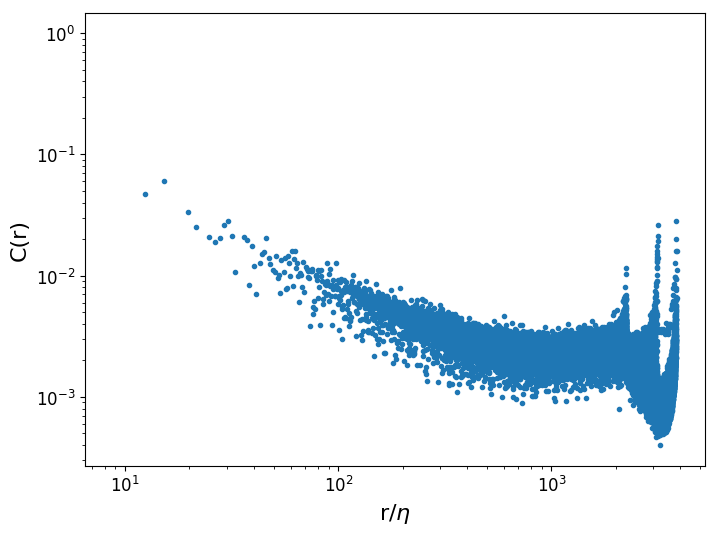

In [113]:
plt.figure( figsize=(8,6), dpi=100 )
plt.loglog( r_values, correlation_normed, '.')
plt.tick_params( axis='both', which='major', labelsize=12 )
xlabel('r/$\eta$', fontsize=16)
ylabel('C(r)', fontsize=16)
#plt.savefig( 'Cr_loglog_pure_adjacent.png', dpi=100 )

In [114]:
where(correlation_normed < 0) # invalid values (!)

(array([], dtype=int64),)

In [115]:
filt = np.logical_and( r_values !=0, correlation_normed != 0 )
filt2 = np.logical_and( correlation_normed > 0, filt )
log_r_values = log10( r_values[ filt2 ] )
log_correlation_normed = log10( correlation_normed[ filt2 ] )

In [116]:
log_r_values.shape, log_correlation_normed.shape

((139628,), (139628,))

In [117]:
log_r_values

array([1.09329688, 1.18134251, 1.29226689, ..., 3.58674653, 3.58674876,
       3.58731535])

In [118]:
def linfit( x, a, b ):
    return a*x+b

# fitting
b = np.logical_and( log_r_values > 1, log_r_values < 2.3 )
log_r_values[b].shape, log_correlation_normed[b].shape
popt, pcov = curve_fit( linfit, log_r_values[b], log_correlation_normed[b] )

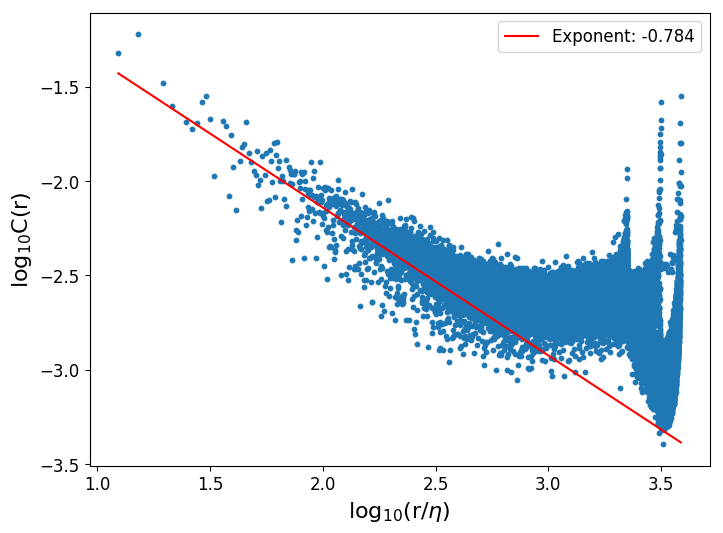

In [119]:
plt.figure( figsize=(8,6), dpi=100 )
#plt.loglog( r_values, correlation_normed, '.')
plt.tick_params( axis='both', which='major', labelsize=12 )
xlabel('log$_{10}$(r/$\eta$)', fontsize=16)
ylabel('log$_{10}$C(r)', fontsize=16)
plt.scatter( log_r_values, log_correlation_normed, s=10, marker='o' )
plt.plot( log_r_values, popt[0]*log_r_values+popt[1], '-', c='r', label='Exponent: '+str(popt[0])[:6] )
plt.legend( fontsize=12 )
#plt.savefig( 'Cr_loglog_linfit_adjacent.png', dpi=100 )

In [120]:
print("Decaying frequency exponent: %.3f +/- %.3f" % (popt[0], np.sqrt(pcov[0,0])))

Decaying frequency exponent: -0.785 +/- 0.028


### Energy spectra

(https://www.researchgate.net/post/How_can_I_obtain_energy_spectrum_from_a_given_3D_turbulent_flow_field)

#### Only fluctuations needed (!)

In [121]:
%%time
# perform 3 dimensional FFT:
Energy_k = np.abs( np.fft.fftn( Energy-mean(Energy), axes=(0,1,2), norm="ortho" ) )
Energy_k.shape, Energy_k[0,0,0] # two sided spectrum in each direction

CPU times: user 1.17 s, sys: 340 ms, total: 1.51 s
Wall time: 1.5 s


#### Calculate the energy spectrum from the first half of the two-sided spectrum with k at zero

##### Generating all points

In [122]:
kx_128 = kx[:128]
ky_128 = ky[:128]
kz_128 = kz[:128]

In [123]:
%%time
kpoints = np.array(list(itertools.product(kx_128, ky_128, kz_128 ) ) ) 

CPU times: user 845 ms, sys: 44 ms, total: 889 ms
Wall time: 886 ms


In [124]:
kpoints[:3]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.99999998],
       [0.        , 0.        , 1.99999997]])

##### Converting to spherical 

In [125]:
%%time
kpoints_sphere = empty( kpoints.shape, dtype=float )
for i in range( kpoints.shape[0] ):
    kpoints_sphere[i] = cart2sph( *kpoints[i] )
kpoints_sphere.shape

CPU times: user 17.9 s, sys: 15.9 ms, total: 17.9 s
Wall time: 17.9 s


In [126]:
E_d_128 = Energy_k[:128,:128,:128] # speratating the first half of the spectrum
E_d_128.shape

(128, 128, 128)

In [127]:
%%time
# sorting indices for the coordinates, sort EVERY column, but radius is the primary
ksort_idx = lexsort( (kpoints_sphere[:,2], kpoints_sphere[:,1], kpoints_sphere[:,0]) )
ksort_idx

CPU times: user 483 ms, sys: 12 ms, total: 495 ms
Wall time: 494 ms


In [128]:
E_d_points = E_d_128.flatten()
kpoints_sphere_r_sorted = kpoints_sphere[ ksort_idx ]
E_d_r_sorted = E_d_points[ ksort_idx ]

In [129]:
E_d_r_sorted.shape, kpoints_sphere_r_sorted.shape

((2097152,), (2097152, 3))

In [130]:
kdiff_between_radii = np.diff(kpoints_sphere_r_sorted[:,0])
kboundaries = argwhere( [ not i for i in isclose( kdiff_between_radii, 0, atol=1e-5 ) ] )
kboundaries.shape

(33140, 1)

In [131]:
ktrue_boundaries = kboundaries.reshape( kboundaries.shape[0] )+1
ktrue_boundaries[:10]

array([ 1,  4,  7,  8, 11, 17, 20, 23, 29, 35])

In [132]:
%%time
E_k = zeros(len(ktrue_boundaries)-1)
k_values = zeros(len(ktrue_boundaries)-1)
for i in range( ktrue_boundaries.shape[0]-1 ):
    upper_limit = ktrue_boundaries[i+1]
    lower_limit = ktrue_boundaries[i]
    
    energy, dist = correl_angular_integrator_simple( lower_limit, upper_limit, 
                                                    kpoints_sphere_r_sorted, E_d_r_sorted )
    E_k[i] = energy
    k_values[i] = dist

CPU times: user 26 s, sys: 4.09 ms, total: 26 s
Wall time: 26 s


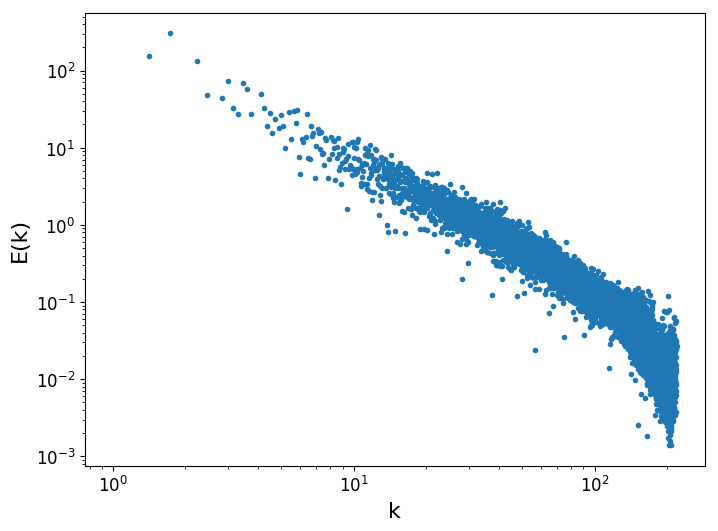

In [133]:
plt.figure( figsize=(8,6), dpi=100 )
plt.loglog( k_values, E_k, '.')
plt.tick_params( axis='both', which='major', labelsize=12 )
xlabel('k', fontsize=16)
ylabel('E(k)', fontsize=16)
plt.savefig( 'E_k_loglog_pure_whole.png', dpi=100 )

In [134]:
filt = np.logical_and( k_values !=0, E_k != 0 )
filt2 = np.logical_and( E_k > 0, filt )
log_k_values = log10( k_values[ filt2 ] )
log_E_k = log10( E_k[ filt2 ] )

In [138]:
def linfit( x, a, b ):
    return a*x+b

# fitting
b = np.logical_and( log_k_values > 0.5, log_k_values < 2.0 )
log_k_values[b].shape, log_E_k[b].shape
popt, pcov = curve_fit( linfit, log_k_values[b], log_E_k[b] )

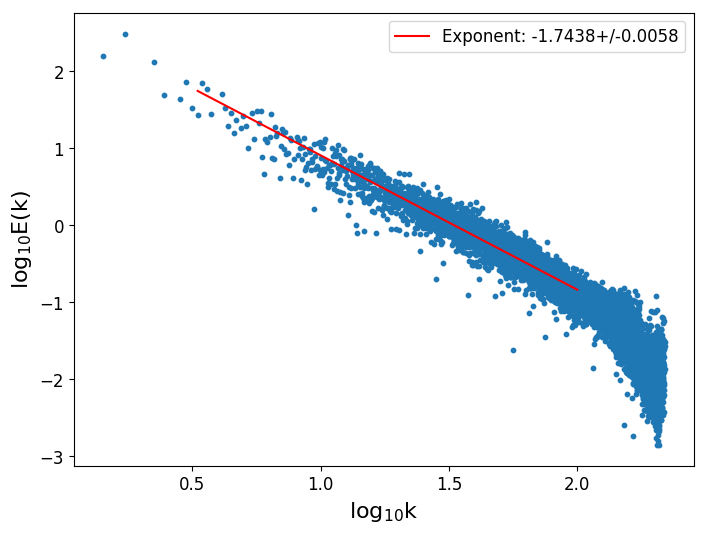

In [139]:
plt.figure( figsize=(8,6), dpi=100 )
#plt.loglog( r_values, correlation_normed, '.')
plt.tick_params( axis='both', which='major', labelsize=12 )
xlabel('log$_{10}$k', fontsize=16)
ylabel('log$_{10}$E(k)', fontsize=16)
plt.scatter( log_k_values, log_E_k, s=10, marker='o' )
plt.plot( log_k_values[b], popt[0]*log_k_values[b]+popt[1], '-', c='r', 
         label='Exponent: '+str(round(popt[0], 4) )+'+/-'+str( round( sqrt(pcov[0,0]) , 4) ) )
plt.legend( fontsize=12 )
plt.savefig( 'Ek_loglog_linfit_whole.png', dpi=100 )

In [137]:
"""[X, Y] = np.meshgrid(2 * np.pi * np.arange(200) / 12, 2 * np.pi * np.arange(200) / 34)
S = np.sin(X) + np.cos(Y) + np.random.uniform(0, 1, X.shape)
FS = np.fft.fftn(S)
plt.imshow(np.log(np.abs(np.fft.fftshift(FS))**2))
plt.show()"""

'[X, Y] = np.meshgrid(2 * np.pi * np.arange(200) / 12, 2 * np.pi * np.arange(200) / 34)\nS = np.sin(X) + np.cos(Y) + np.random.uniform(0, 1, X.shape)\nFS = np.fft.fftn(S)\nplt.imshow(np.log(np.abs(np.fft.fftshift(FS))**2))\nplt.show()'